<a href="https://colab.research.google.com/github/the-bucketless/phf_tutorial/blob/main/phf_ladder_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is meant as an example of how to use Python to re-create [Alyssa Longmuir](https://twitter.com/alyssastweeting)'s ladder chart from her recent [twitch stream](https://www.twitch.tv/videos/1190638895) for getting started with PHF data in R. I've tried to keep things as similar as possible to what you see there (which is my way of saying, if you see things you don't like, blame Alyssa). We'll try to follow along with the stream while putting our ladder together.

# Data Sources

Some sources of data for the Premier Hockey Federation (PHF, formerly NWHL).

[Their Hockey Counts](https://theirhockeycounts.com) courtesy [Mike Murphy](https://twitter.com/DigDeepBSB).  
[PHF play-by-play scraper (in R)](https://github.com/benhowell71/whockeyR) courtesy [Ben Howell](https://twitter.com/benhowell71).  


This quick tutorial will use Ben's play-by-play scraper to grab our data.

# Loading Data

There isn't currently a Python version of the scraper.  This complicates things, but thanks to rpy2, we can make do with the R package.

In [1]:
import pandas as pd
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import seaborn as sns

%matplotlib inline

This next cell imports the R package for scraping play-by-play data. It'll ask for input before running. Just press Enter and things should go. Though, fair warning, it can take a few minutes to run.

In [2]:
devtools = rpackages.importr("devtools")
devtools.install_github("BenHowell71/whockeyR", quiet=True)

These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

1: All                             
2: CRAN packages only              
3: None                            
4: openssl  (1.4.3 -> 1.4.5) [CRAN]
5: cli      (3.0.1 -> 3.1.0) [CRAN]
6: crayon   (1.4.1 -> 1.4.2) [CRAN]
7: generics (0.1.0 -> 0.1.1) [CRAN]
8: usethis  (2.1.0 -> 2.1.3) [CRAN]

Enter one or more numbers, or an empty line to skip updates: 


R[write to console]: Installing 8 packages: RcppParallel, stringfish, RApiSerialize, snakecase, xgboost, qs, progressr, janitor



'whockeyR'


We should have the package now, so let's import it and get to work.

In [3]:
whockeyR = rpackages.importr("whockeyR")

Alyssa first checked out the schedule, focusing on the Boston Pride.  We'll follow suit.  

I couldn't get the rpy2 functions working to convert R DataFrames to pandas DataFrames, so we're going to load the data, save it to a csv, and then load the csv with pandas. Whatever works.

In [4]:
schedule = whockeyR.phf_schedule(season=2021)
schedule.to_csvfile("/content/schedule.csv")
schedule = pd.read_csv("/content/schedule.csv")

schedule.head()

,type,id,league_id,season_id,tournament_id,game_id,number,datetime,datetime_tz,time_zone,time_zone_abbr,updated_at,created_at,home_team_id,home_team,home_team_short,home_team_logo_url.full,home_team_logo_url.small,home_team_logo_url.medium,home_team_logo_url.large,home_team_logo_url.50,home_team_logo_url.100,home_team_logo_url.200,away_team_id,away_team,away_team_short,away_team_logo_url.full,away_team_logo_url.small,away_team_logo_url.medium,away_team_logo_url.large,away_team_logo_url.50,away_team_logo_url.100,away_team_logo_url.200,home_division_id,home_division,away_division_id,away_division,home_score,away_score,facility_id,facility,facility_address,rink_id,rink,game_type,notes,status,overtime,shootout,allow_players,tickets_url,watch_live_url,external_url,has_play_by_play,highlight_color,date_group,winner
1,game,g-368723,100,2779,NaN,368723,NaN,2021-01-23T13:00:00+00:00,2021-01-23 18:00:00 +0000,US/Eastern,EST,2021-08-20 20:00:12 +0000,2021-01-14 15:30:29 +0000,97011,Metropolitan Riveters,MET,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,97014,Toronto Toronto,TOR,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,11112,NWHL,11112,NWHL,3,0,4007.0,Herb Brooks Arena,2634%20Main%20St%2C%20Lake%20Placid%2C%20NY%2C...,NaN,NaN,Regular Season,NaN,Final,False,False,True,https://ci.ovationtix.com/35236,https://www.premierhockeyfederation.com/phf-on...,NaN,True,NaN,2021-01-23,Metropolitan Riveters
2,game,g-368719,100,2779,NaN,368719,NaN,2021-01-23T16:00:00+00:00,2021-01-23 21:00:00 +0000,US/Eastern,EST,2021-10-19 14:32:54 +0000,2021-01-14 15:30:29 +0000,97016,Minnesota Whitecaps,MIN,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,97010,Boston Pride,BOS,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,11112,NWHL,11112,NWHL,2,1,4007.0,Herb Brooks Arena,2634%20Main%20St%2C%20Lake%20Placid%2C%20NY%2C...,NaN,NaN,Regular Season,NaN,Final,False,False,True,https://ci.ovationtix.com/35233,https://www.premierhockeyfederation.com/phf-on...,NaN,True,NaN,2021-01-23,Minnesota Whitecaps
3,game,g-368721,100,2779,NaN,368721,NaN,2021-01-23T19:00:00+00:00,2021-01-24 00:00:00 +0000,US/Eastern,EST,2021-03-28 18:50:14 +0000,2021-01-14 15:30:29 +0000,97008,Buffalo Beauts,BUF,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,97015,Connecticut Whale,CTW,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c

In [5]:
boston_schedule = schedule.loc[schedule.home_team == "Boston Pride"]
boston_schedule.head()

,type,id,league_id,season_id,tournament_id,game_id,number,datetime,datetime_tz,time_zone,time_zone_abbr,updated_at,created_at,home_team_id,home_team,home_team_short,home_team_logo_url.full,home_team_logo_url.small,home_team_logo_url.medium,home_team_logo_url.large,home_team_logo_url.50,home_team_logo_url.100,home_team_logo_url.200,away_team_id,away_team,away_team_short,away_team_logo_url.full,away_team_logo_url.small,away_team_logo_url.medium,away_team_logo_url.large,away_team_logo_url.50,away_team_logo_url.100,away_team_logo_url.200,home_division_id,home_division,away_division_id,away_division,home_score,away_score,facility_id,facility,facility_address,rink_id,rink,game_type,notes,status,overtime,shootout,allow_players,tickets_url,watch_live_url,external_url,has_play_by_play,highlight_color,date_group,winner
6,game,g-368724,100,2779,NaN,368724,NaN,2021-01-24T19:00:00+00:00,2021-01-25 00:00:00 +0000,US/Eastern,EST,2021-10-20 22:16:06 +0000,2021-01-14 15:30:29 +0000,97010,Boston Pride,BOS,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,97008,Buffalo Beauts,BUF,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,11112,NWHL,11112,NWHL,5,1,4007.0,Herb Brooks Arena,2634%20Main%20St%2C%20Lake%20Placid%2C%20NY%2C...,NaN,NaN,Regular Season,NaN,Final,False,False,True,https://ci.ovationtix.com/35234,https://www.premierhockeyfederation.com/phf-on...,NaN,True,NaN,2021-01-24,Boston Pride
8,game,g-368726,100,2779,NaN,368726,NaN,2021-01-26T20:30:00+00:00,2021-01-27 01:30:00 +0000,US/Eastern,EST,2021-01-27 04:04:06 +0000,2021-01-14 15:30:30 +0000,97010,Boston Pride,BOS,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,97014,Toronto Toronto,TOR,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,11112,NWHL,11112,NWHL,1,2,4007.0,Herb Brooks Arena,2634%20Main%20St%2C%20Lake%20Placid%2C%20NY%2C...,NaN,NaN,Regular Season,NaN,Final,False,False,True,https://ci.ovationtix.com/35234,https://www.premierhockeyfederation.com/phf-on...,NaN,True,NaN,2021-01-26,Toronto Toronto
13,game,g-371881,100,2779,NaN,371881,NaN,2021-01-31T15:00:00+00:00,2021-01-31 20:00:00 +0000,US/Eastern,EST,2021-02-03 03:43:38 +0000,2021-01-29 23:56:03 +0000,97010,Boston Pride,BOS,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,97008,Buffalo Beauts,BUF,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.shiftstats.com/dcd7c2ef-0bf7-4a7e-...,https://img.s

For the play-by-play, Alyssa chose the game against Toronto (ID 368726), but copied the wrong ID into her session (she missed the 6 at the end of the ID making it 36872). When she got an error, she assumed it was a bug in the package. We'll follow along with the default game to recreate what she did, but if you want to see what she missed out on (or check out any other game you're interested in), update the following cell.

In [6]:
game_id = "268078"    #@param {type:"string"}

In [7]:
pbp = whockeyR.load_pbp(game_id)
pbp.to_csvfile("/content/pbp.csv")
pbp = pd.read_csv("/content/pbp.csv")

pbp.head()

,game_id,home_team,away_team,period_id,event_no,description,time_remaining,sec_from_start,on_ice_situation,home_skaters,away_skaters,home_goals,away_goals,leader,team,event,first_player,first_number,second_player,second_number,third_player,third_number,shot_type,shot_result,goalie_involved,penalty,penalty_length,penalty_called,offensive_player_one,offensive_player_two,offensive_player_three,offensive_player_four,offensive_player_five,offensive_player_six,home_goalie,away_goalie
1,268078,Connecticut Whale,Buffalo Beauts,1,1,#24 Sarah Hughson giveaway to #4 Marie-Jo Pell...,19:47,13,Even Strength,5,5,0,0,T,Connecticut WhaleCTW,Giveaway,Sarah Hughson,24.0,Marie-Jo Pelletier,4.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonjia Shelly,Mariah Fujimagari
2,268078,Connecticut Whale,Buffalo Beauts,1,2,#4 Marie-Jo Pelletier giveaway to #6 Shannon D...,19:43,17,Even Strength,5,5,0,0,T,Buffalo BeautsBUF,Giveaway,Marie-Jo Pelletier,4.0,Shannon Doyle,6.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonjia Shelly,Mariah Fujimagari
3,268078,Connecticut Whale,Buffalo Beauts,1,3,#22 Becki Bowering saved by #31 Sonjia Shelly,19:11,49,Even Strength,5,5,0,0,T,Buffalo BeautsBUF,Shot,Becki Bowering,22.0,Sonjia Shelly,31.0,NaN,NaN,NaN,saved,Sonjia Shelly,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonjia Shelly,Mariah Fujimagari
4,268078,Connecticut Whale,Buffalo Beauts,1,4,#19 Ashley Birdsall blocked by #21 Sarah Schwe...,18:24,96,Even Strength,5,5,0,0,T,Buffalo BeautsBUF,Shot BLK,Ashley Birdsall,19.0,Sarah Schwenzfeier,21.0,NaN,NaN,NaN,blocked,Sonjia Shelly,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonjia Shelly,Mariah Fujimagari
5,268078,Connecticut Whale,Buffalo Beauts,1,5,#88 Sara Bustad faceoff won against #16 Hanna ...,17:59,121,Even Strength,5,5,0,0,T,Buffalo BeautsBUF,Faceoff,Sara Bustad,88.0,Hanna Beattie,16.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonjia Shelly,Mariah Fujimagari


# Ladder Chart

Now we're going to try to recreate the ladder chart. This won't look quite the same as the one Alyssa made because of the differences between ggplot and seaborn's defaults, but we'll call it the seaborn equivalent.

## Prepare data

First, we have to put the data together in the same way Alyssa did. We're going to count up the shots for each team while keeping some data we're going to use in the chart.

In [16]:
shots = pbp.copy().loc[pbp.event.isin(["PP Goal", "Goal", "Pen Shot", "Shot"])]
shots["n"] = 1

shot_columns = ["period_id", "sec_from_start", "team", "event", "first_player"]
shot_count_df = (
    shots.groupby(shot_columns, as_index=False, sort=False)["n"]
    .sum()
    .sort_values("team", kind="mergesort")
)

shot_count_df["count"] = shot_count_df.groupby("team")["n"].cumsum()

In [17]:
shot_count_df

,period_id,sec_from_start,team,event,first_player,n,count
0,1,49,Buffalo BeautsBUF,Shot,Becki Bowering,1,1
1,1,265,Buffalo BeautsBUF,Shot,Corinne Buie,1,2
2,1,269,Buffalo BeautsBUF,PP Goal,Lenka Curmova,1,3
6,1,992,Buffalo BeautsBUF,Shot,Megan,1,4
8,2,1233,Buffalo BeautsBUF,Shot,Lenka Curmova,1,5
10,2,1279,Buffalo BeautsBUF,Shot,Cassidy MacPherson,1,6
13,2,1406,Buffalo BeautsBUF,Shot,Becki Bowering,1,7
14,2,1476,Buffalo BeautsBUF,Shot,Iveta Klimasova,1,8
17,2,1720,Buffalo BeautsBUF,Shot,Becki Bowering,1,9
18,2,1730,Buffalo BeautsBUF,Shot,Ana Orzechowski,1,10


## Plotting

Now, we can climb some ladders. Since this is a notebook and not a stream, we'll show several iterations of the same plot with different elements added in. If you're not interested in seeing how things evolve, feel free to skip to the end. To ensure that each cell works without having to run the previous plots (and hopefully they do), we'll be copying some code that otherwise oughtn't be copied.  

We'll start with the basic step plot.

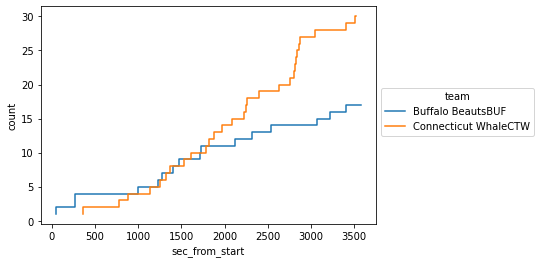

In [18]:
ladder = sns.lineplot(data=shot_count_df, x="sec_from_start", y="count", hue="team", drawstyle="steps");
ladder.legend(bbox_to_anchor=(1, 0.65), title="team");

Next, we'll update the data along the x-axis to show periods instead of seconds.

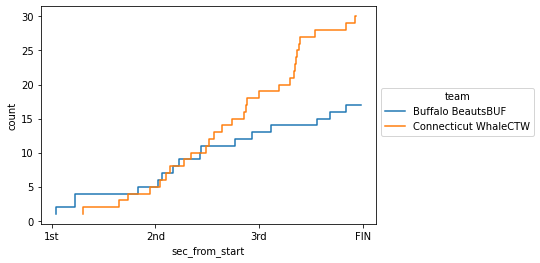

In [19]:
ladder = sns.lineplot(data=shot_count_df, x="sec_from_start", y="count", hue="team", drawstyle="steps");
ladder.legend(bbox_to_anchor=(1, 0.65), title="team");
ladder.xaxis.set_ticks([0, 1200, 2400, 3600]);
ladder.xaxis.set_ticklabels(["1st", "2nd", "3rd", "FIN"]);

Next, we'll play with the color scheme. I don't know why Toronto is listed as Toronto Toronto, but we'll go with it.

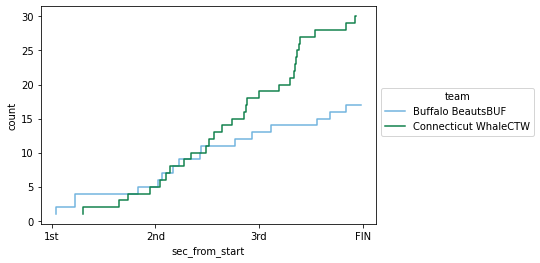

In [20]:
team_colours = {
    "Boston PrideBOS": "#fec52e", 
    "Buffalo BeautsBUF": "#71b4df", 
    "Connecticut WhaleCTW": "#11814c",
    "Minnesota WhitecapsMIN": "#163b8a",
    "Metropolitan RivetersMET": "#26324c",
    "Toronto SixTOR": "#ff0000",
    "Toronto TorontoTOR": "#ff0000",
}

ladder = sns.lineplot(data=shot_count_df, x="sec_from_start", y="count", hue="team", 
                      drawstyle="steps", palette=team_colours);
ladder.legend(bbox_to_anchor=(1, 0.65), title="team");
ladder.xaxis.set_ticks([0, 1200, 2400, 3600]);
ladder.xaxis.set_ticklabels(["1st", "2nd", "3rd", "FIN"]);

Next, we'll add in some vertical lines for goals. There could be some overlap in the labels with the defaults. This would be an easy spot to make some improvements.

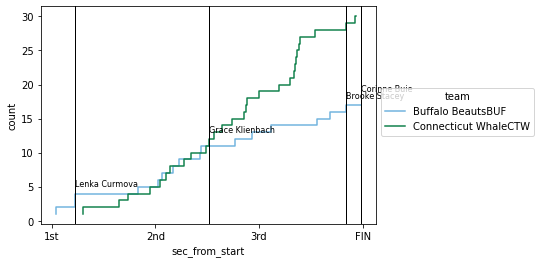

In [21]:
team_colours = {
    "Boston PrideBOS": "#fec52e", 
    "Buffalo BeautsBUF": "#71b4df", 
    "Connecticut WhaleCTW": "#11814c",
    "Minnesota WhitecapsMIN": "#163b8a",
    "Metropolitan RivetersMET": "#26324c",
    "Toronto SixTOR": "#ff0000",
    "Toronto TorontoTOR": "#ff0000",
}

ladder = sns.lineplot(data=shot_count_df, x="sec_from_start", y="count", hue="team", 
                      drawstyle="steps", palette=team_colours);
ladder.legend(bbox_to_anchor=(1, 0.65), title="team");
ladder.xaxis.set_ticks([0, 1200, 2400, 3600]);
ladder.xaxis.set_ticklabels(["1st", "2nd", "3rd", "FIN"]);

goals = shot_count_df.loc[shot_count_df.event.isin(["Goal", "PP Goal"])]
max_shot = shot_count_df["count"].max()
for goal in goals.itertuples():
    ladder.axvline(goal.sec_from_start, label=goal.first_player, color="black", linewidth=1);
    ladder.text(goal.sec_from_start, goal.count + 2, goal.first_player, size=8);

Next, we'll add a title and a caption and adjust the size of the rungs of the ladder.

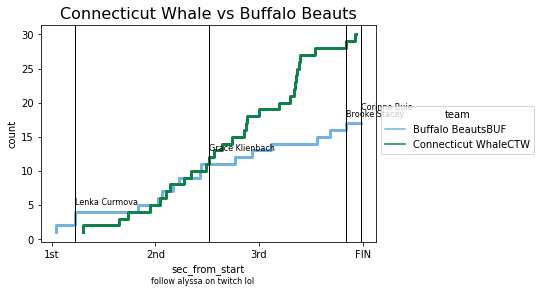

In [22]:
team_colours = {
    "Boston PrideBOS": "#fec52e", 
    "Buffalo BeautsBUF": "#71b4df", 
    "Connecticut WhaleCTW": "#11814c",
    "Minnesota WhitecapsMIN": "#163b8a",
    "Metropolitan RivetersMET": "#26324c",
    "Toronto SixTOR": "#ff0000",
    "Toronto TorontoTOR": "#ff0000",
}

ladder = sns.lineplot(data=shot_count_df, x="sec_from_start", y="count", hue="team", 
                      drawstyle="steps", palette=team_colours, linewidth=3);
ladder.legend(bbox_to_anchor=(1, 0.65), title="team");
ladder.xaxis.set_ticks([0, 1200, 2400, 3600]);
ladder.xaxis.set_ticklabels(["1st", "2nd", "3rd", "FIN"]);

goals = shot_count_df.loc[shot_count_df.event.isin(["Goal", "PP Goal"])]
max_shot = shot_count_df["count"].max()
for goal in goals.itertuples():
    ladder.axvline(goal.sec_from_start, label=goal.first_player, color="black", linewidth=1);
    ladder.text(goal.sec_from_start, goal.count + 2, goal.first_player, size=8);

ladder.set_title(f"{pbp.home_team.iloc[0]} vs {pbp.away_team.iloc[0]}", size=16);
ladder.figure.text(0.5, -0.02, "follow alyssa on twitch lol", ha="center", size=8);

And that's as far as Alyssa got, so we'll stop there. Or I will. Feel free to play around with it.